### Step 52 GPU 지원

- 딥러닝에서의 계산은 대부분 행렬의 곱
- 행렬의 곱은 곱셈과 덧셈으로 구성되므로 병렬로 계산 가능
- 병렬 계산에는 GPU가 뛰어남
- GPU 실행을 위해 NVIDIA GPU와 파이썬 라이브러리 `CuPy`가 필요

(`pip install cupy` 했는데 안돼서 `pip install cupy-cuda11x`로 설치함 (Ubuntu 20.04))

In [1]:
import cupy as cp
x = cp.arange(6).reshape(2, 3)
print(x)
y = x.sum(axis=1)
print(y)

[[0 1 2]
 [3 4 5]]
[ 3 12]


In [2]:
import numpy as np

# numpy -> cupy
n = np.array([1, 2, 3])
c = cp.asarray(n)
assert type(c) == cp.ndarray

# cupy -> numpy
c = cp.array([1, 2, 3])
n = cp.asnumpy(c)
assert type(n) == np.ndarray

In [3]:
# when x is numpy array
x = np.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == np

# when x is cupy array
x = cp.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == cp

In [4]:
# CUDA 모듈
gpu_enable = True
try:
    import cupy as cp
    cupy = cp
except ImportError:
    gpu_enable = False
from dezero import Variable

def get_array_module(x):
    if isinstance(x, Variable):
        x = x.data
    
    if not gpu_enable:
        return np
    xp = cp.get_array_module(x)
    return xp

def as_numpy(x):
    if isinstance(x, Variable):
        x = x.data
    
    if np.isscalar(x):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return cp.asnumpy(x)

def as_cupy(x):
    if isinstance(x, Variable):
        x = x.data
    
    if not gpu_enable:
        raise Exception('쿠파이(Cupy)를 로드할 수 없습니다. 쿠파이를 설치해주세요!')
    return cp.asarray(x)

In [5]:
import dezero 

# dezero/core.py에 추가
# ...
try:
    import cupy
    array_types = (np.ndarray, cupy.ndarray)
except ImportError:
    array_types = (np.ndarray)

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, array_types):
                raise TypeError('{} is not supported'.format(type(data)))
        # ...
    
    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None:
            xp = dezero.cuda.get_array_module(self.data)
            self.grad = Variable(xp.ones_like(self.data))
        # ...
    
    # ...
    def to_cpu(self):
        if self.data is not None:
            self.data = dezero.cuda.as_numpy(self.data)
        
    def to_gpu(self):
        if self.data is not None:
            self.data = dezero.cuda.as_cupy(self.data)

In [6]:
# dezero/layers.py에 추가
class Layer:
    # ...
    def to_cpu(self):
        for param in self.params():
            param.to_cpu()
    
    def to_gpu(self):
        for param in self.params():
            param.to_gpu()

In [7]:
import math

# dezero/dataloaders.py에 추가
from dezero import cuda

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True, gpu=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)
        self.gpu = gpu #

        self.reset()
    
    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration

        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        
        xp = cuda.cupy if self.gpu else np # 
        x = xp.array([example[0] for example in batch]) #
        t = xp.array([example[1] for example in batch]) #

        self.iteration += 1

        return x, t
    
    def to_cpu(self): #
        self.gpu = False #
     
    def to_gpu(self): #
        self.gpu = True #

In [8]:
from dezero import Function

# dezero/functions.py에 추가
class Sin(Function):
    def forward(self, x):
        xp = cuda.get_array_module(x) #
        y = xp.sin(x) #
        return y
    
    def backward(self, gy):
        x, = self.inputs
        gx = gy * cos(x)
        return gx

In [9]:
# dezero/core.py 수정
def as_array(x, array_module=np):
    if np.isscalar(x):
        return array_module.array(x)
    return x

def add(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Add()(x0, x1)

def mul(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Mul()(x0, x1)

# sub, rsub, div, rdiv도 똑같이 수정

In [10]:
# GPU로 MNIST 학습하기
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# GPU 모드
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()

for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

epoch: 1, loss: 1.9134, time: 3.5797[sec]
epoch: 2, loss: 1.2815, time: 2.4703[sec]
epoch: 3, loss: 0.9239, time: 2.4535[sec]
epoch: 4, loss: 0.7395, time: 2.4623[sec]
epoch: 5, loss: 0.6350, time: 2.4544[sec]


### Step 53 모델 저장 및 읽어오기

In [11]:
import numpy as np

x = np.array([1, 2, 3])
np.save('test.npy', x)

x = np.load('test.npy')
print(x)

[1 2 3]


In [12]:
# 여러 ndarray 인스턴스 저장 및 로드
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])

np.savez('test.npz', x1=x1, x2=x2)

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


In [13]:
# Layer 클래스의 매개변수를 평평하게
from dezero import Parameter, Layer

layer = Layer()
l1 = Layer()
l1.p1 = Parameter(np.array(1))

layer.l1 = l1
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))

In [14]:
params_dict = {}
layer._flatten_params(params_dict)
print(params_dict)

{'l1/p1': variable(1), 'p2': variable(2), 'p3': variable(3)}


In [15]:
class Layer:
    # ...
    def _flatten_params(self, params_dict, parent_key=''):
        for name in self._params:
            obj = self.__dict__[name]
            key = parent_key + '/' + name if parent_key else name

            if isinstance(obj, Layer): # obj가 Layer라면 한번 더 꺼내야 함
                obj._flatten_params(params_dict, key)
            else:
                params_dict[key] = obj

In [16]:
# Layer 클래스의 save 함수와 load 함수
import os
class Layer:
    # ...
    def save_weights(self, path):
        self.to_cpu()

        params_dict = {}
        self._flatten_params(params_dict)
        array_dict = {key: param.data for key, param in params_dict.items()
                        if param is not None}
        try:
            np.savez_compressed(path, **array_dict)
        except(Exception, KeyboardInterrupt) as e:
            if os.path.exists(path):
                os.remove(path)
            raise
    
    def load_weights(self, path):
        npz = np.load(path)
        params_dict = {}
        self._flatten_params(params_dict)
        for key, param in params_dict.items():
            param.data = npz[key]

In [17]:
# MNIST 학습
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 3
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# 매개변수 읽기
if os.path.exists('my_mlp.npz'):
    model.load_weights('my_mlp.npz')

for epoch in range(max_epoch):
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    print('epoch: {}, loss: {:.4f}'.format(
        epoch + 1, sum_loss / len(train_set)))

# 매개변수 저장하기
model.save_weights('my_mlp.npz')

epoch: 1, loss: 0.4430
epoch: 2, loss: 0.4271
epoch: 3, loss: 0.4140


### Step 54 드롭아웃과 테스트모드

과대적합 원인 => 해결방법:
- 훈련 데이터가 적음 => Data augmentation
- 모델의 표현력이 지나치게 높음 => Weight decay, Dropout, Batch normalization

In [18]:
import numpy as np
np.random.seed(42)

dropout_ratio = 0.6
x = np.ones(10)

mask = np.random.rand(10) > dropout_ratio
y = x * mask
y

array([0., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

In [19]:
# 학습 시에는 데이터를 흘려보낼 때 선별적 비활성화 수행
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask

# 테스트 시에는 모든 뉴런을 사용하면서도 앙상블 학습처럼 동작하게끔 '흉내'내야 함
scale = 1 - dropout_ratio # 학습 시 살아남은 뉴런의 비율
y = x * scale

##### Inverted Dropout (역 드롭아웃): 스케일 맞추기를 학습할 때 수행\

장점: 테스트 속도 (약간) 향상 / 학습 시 dropout_ratio를 동적으로 변경 가능

In [20]:
# 학습 시
scale = 1 - dropout_ratio
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask / scale

# 테스트 시
y = x

In [21]:
# 테스트 모드 추가 (dezero/core.py)
import contextlib

class Config:
    enable_backprop = True
    train = True

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    yield
    setattr(Config, name, old_value)

def test_mode():
    return using_config('train', False)

In [22]:
# 드롭아웃 구현 (dezero/functions.py)
def dropout(x, dropout_ratio=0.5):
    x = as_variable(x)

    if dezero.Config.train:
        xp = cuda.get_array_module(x)
        mask = xp.random.rand(*x.shape) > dropout_ratio
        scale = xp.array(1.0 - dropout_ratio).astype(x.dtype)
        y = x * mask / scale
        return y
    else:
        return x    

In [23]:
# dropout 사용
from dezero import test_mode
x = np.ones(5)
print(x)

# 학습 시
y = F.dropout(x)
print(y)

# 테스트 시
with test_mode():
    y = F.dropout(x)
    print(y)

[1. 1. 1. 1. 1.]
variable([2. 0. 0. 2. 2.])
variable([1. 1. 1. 1. 1.])


### Step 55 CNN 메커니즘(1)

In [24]:
# 출력 크기 계산
def get_conv_outsize(input_size, kernel_size, stride, pad):
    return (input_size + 2 * pad - kernel_size) // stride + 1

In [25]:
H, W = 4, 4 # Image shape
KH, KW = 3, 3 # Kernel shape
SH, SW = 1, 1 # Stride
PH, PW = 1, 1 # Padding

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


### Step 56 CNN 메커니즘(2)
Pooling층 특징
- 학습하는 매개변수가 없다
- 채널 수가 변하지 않는다
- 미세한 위치 변화에 영향을 덜 받는다

### Step 57 conv2d 함수와 pooling 함수

In [26]:
# img2col 함수 사용
x1 = np.random.rand(1, 3, 7, 7) # 배치크기 1
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) # 배치크기 10
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=False)
print(col2.shape)

(9, 75)
(90, 75)
(10, 3, 5, 5, 3, 3)


In [27]:
# 편의 함수
def pair(x):
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, tuple):
        assert len(x) == 2
        return x
    else:
        raise ValueError

In [28]:
# from dezero.utils import pair
print(pair(1))
print(pair((1, 2)))

(1, 1)
(1, 2)


In [29]:
# dezero/funtions_conv.py
from dezero.utils import as_variable
from dezero.functions import im2col, linear

def conv2d_simple(x, W, b=None, stride=1, pad=0):
    x, W = as_variable(x), as_variable(W)

    Weight = W
    N, C, H, W = x.shape
    OC, C, KH, KW = Weight.shape
    SH, SW = pair(stride)
    PH, PW = pair(pad)
    OH = get_conv_outsize(H, KH, SH, PH)
    OW = get_conv_outsize(W, KW, SW, PW)

    col = im2col(x, (KH, KW), stride, pad, to_matrix=True)
    Weight = Weight.reshape(OC, -1).transpose()
    t = linear(col, Weight, b)
    y = t.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2)
    return y

In [30]:
# conv2d_simple 사용
from dezero import Variable
N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)

x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()

print(y.shape)
print(x.grad.shape)

(1, 8, 15, 15)
(1, 5, 15, 15)


In [31]:
# Conv2d 클래스 구현
class Conv2d(Layer):
    def __init__(self, out_channels, kernel_size, stride=1,
                 pad=0, nobias=False, dtype=np.float32, in_channels=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if in_channels is not None:
            self._init_W()
        
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_channels, dtype=dtype), name='b')
    
    def _init_W(self, xp=np):
        C, OC = self.in_channels, self.out_channels
        KH, KW = pair(self.kernel_size)
        scale = np.sqrt(1 / (C * KH * KW))
        W_data = xp.random.randn(OC, C, KH, KW).astype(self.dtype) * scale
        self.W.data = W_data
    
    def forward(self, x):
        if self.W.data is None:
            self.in_channels = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)

        y = F.conv2d_simple(x, self.W, self.b, self.stride, self.pad)
        return y

In [32]:
# Pooling 함수 구현: 채널 방향과는 독립적
def pooling_simple(x, kernel_size, stride=1, pad=0):
    x = as_variable(x)

    N, C, H, W = x.shape
    KH, KW = pair(kernel_size)
    PH, PW = pair(pad)
    SH, SW = pair(stride)
    OH = get_conv_outsize(H, KH, PH, SH)
    OW = get_conv_outsize(W, KW, SW, PW)

    col = im2col(x, kernel_size, stride, pad, to_matrix=True) # 전개
    col = col.reshape(-1, KH * KW)
    y = col.max(axis=1) # 최댓값
    y = y.reshape(N, OH, OW, C).transpose(0, 3, 1, 2) # 형상 변환
    return y

### Step 58 대표적인 CNN (VGG19)

In [33]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class VGG16(Model):
    def __init__(self):
        super().__init__()

        self.conv1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_2 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_3 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv4_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(4096)
        self.fc7 = L.Linear(4096)
        self.fc8 = L.Linear(1000)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1))
        x = F.dropout(F.relu(self.fc6(x)))
        x = F.dropout(F.relu(self.fc7(x)))
        x = self.fc8(x)
        return x

In [34]:
# pretrained model 추가
from dezero import utils

class VGG16(Model):
    WEIGHTS_PATH = 'https://github.com/koki0702/dezero-models/' \
                'releases/download/v0.1/vgg16.npz'
    
    def __init__(self, pretrained=False):
        super().__init__()

        self.conv1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_2 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_3 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv4_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(4096)
        self.fc7 = L.Linear(4096)
        self.fc8 = L.Linear(1000)

        if pretrained:
            weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
            self.load_weights(weights_path)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1))
        x = F.dropout(F.relu(self.fc6(x)))
        x = F.dropout(F.relu(self.fc7(x)))
        x = self.fc8(x)
        return x

In [51]:
model = VGG16(pretrained=True)

x = np.random.randn(1, 3, 224, 224).astype(np.float32)
model.plot(x)

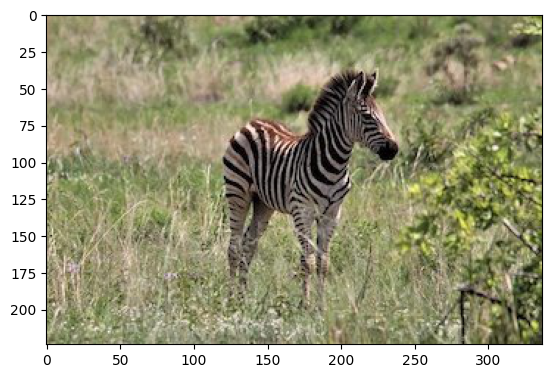

In [49]:
# 샘플 이미지
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

url = 'https://github.com/WegraLee/deep-learning-from-scratch-3/' \
    'raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path)
plt.imshow(np.asarray(img))

In [52]:
from dezero.models import VGG16

x = VGG16.preprocess(img)
print(type(x), x.shape)

<class 'numpy.ndarray'> (3, 224, 224)


In [53]:
# 분류해보기
x = x[np.newaxis] # 배치용 축 추가
model = VGG16(pretrained=True)
with dezero.test_mode():
    y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf')
labels = dezero.datasets.ImageNet.labels() # 이미지넷의 레이블
print(labels[predict_id])

Downloading: imagenet1000_clsidx_to_labels.txt
[##############################] 100.00% Done
zebra


### Step 59 RNN을 활용한 시계열 데이터 처리

In [55]:
from dezero.layers import Linear

# dezero/layers.py
class RNN(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()
        self.x2h = Linear(hidden_size, in_size=in_size)
        self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
        self.h = None
    
    def reset_state(self):
        self.h = None
    
    def forward(self, x):
        if self.h is None:
            h_new = F.tanh(self.x2h(x))
        else:
            h_new = F.tanh(self.x2h(x) + self.h2h(self.h))
    
        self.h = h_new
        return h_new

In [56]:
rnn = L.RNN(10) # 은닉층 크기만 지정
x = np.random.rand(1, 1)
print(x)
h = rnn(x)
print(h, h.shape)

[[0.50109992]]
variable([[ 0.80305591  0.75915743  0.50790052 -0.44442481  0.26015433  0.29278122
           -0.05002152 -0.54313364 -0.22763555 -0.89187722]]) (1, 10)


In [58]:
# steps/step59.py
class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)
    
    def reset_state(self):
        self.rnn.reset_state()
    
    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y   

In [59]:
seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:] # 정답 데이터: xs보다 한 단계 앞선 데이터

model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)

    cnt += 1

    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

- 일련의 입력 데이터로 구성된 계산 그래프에서 역전파를 하는 것을 *BPTT(Backpropagation Through Time)*라고 한다.
- RNN에서는 입력 데이터 개수에 상관없이 계산 그래프가 길게 뻗어나갈 수 있다. 그러나 역전파를 잘 하려면 계산 그래프를 적당한 길이에서 끊어줘야 한다. 이것을 *Truncated BPTT*라고 한다.
- Truncated BPTT를 수행할 때 RNN의 은닉 상태가 유지된다. (다음 반복 때 최초의 은닉 상태는 이전의 마지막 은닉 상태에서 시작)

In [ ]:
# 연결을 끊어주는 메서드
class Variable:
    # ...

    def unchain(self):
        self.creator = None # 부모 함수로의 연결을 끊는다.

    def unchain_backward(self):
        if self.creator is not None:
            funcs = [self.creator]
            while funcs:
                f = funcs.pop()
                for x in f.inputs:
                    if x.creator is not None:
                        funcs.append(x.creator)
                        x.unchain()

999
(array([-0.01061071]), array([0.03838144]))
(array([0.03838144]), array([0.00057258]))
(array([0.00057258]), array([0.01643158]))


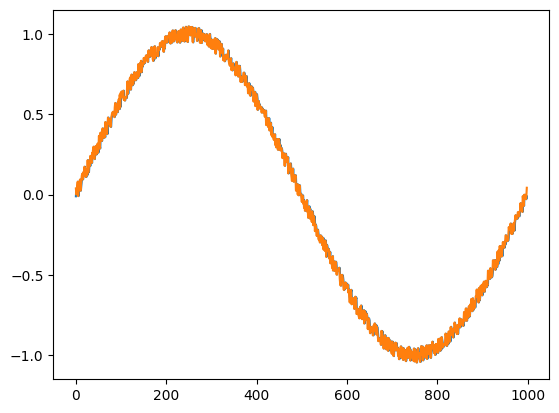

In [66]:
# RNN 사용하여 Sine wave 예측
train_set = dezero.datasets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

# 그래프 그리기
xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

In [67]:
max_epoch = 100
hidden_size = 100
bptt_length = 30
train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1
        
        # Truncated BPTT 타이밍 조정
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
        
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.216067
| epoch 2 | loss 0.037009
| epoch 3 | loss 0.011109
| epoch 4 | loss 0.004020
| epoch 5 | loss 0.004178
| epoch 6 | loss 0.002181
| epoch 7 | loss 0.002619
| epoch 8 | loss 0.002179
| epoch 9 | loss 0.002490
| epoch 10 | loss 0.003623
| epoch 11 | loss 0.005418
| epoch 12 | loss 0.006407
| epoch 13 | loss 0.005499
| epoch 14 | loss 0.004440
| epoch 15 | loss 0.004278
| epoch 16 | loss 0.004712
| epoch 17 | loss 0.005257
| epoch 18 | loss 0.005446
| epoch 19 | loss 0.005163
| epoch 20 | loss 0.004753
| epoch 21 | loss 0.004518
| epoch 22 | loss 0.004481
| epoch 23 | loss 0.004556
| epoch 24 | loss 0.004661
| epoch 25 | loss 0.004747
| epoch 26 | loss 0.004802
| epoch 27 | loss 0.004839
| epoch 28 | loss 0.004863
| epoch 29 | loss 0.004863
| epoch 30 | loss 0.008101
| epoch 31 | loss 0.047791
| epoch 32 | loss 0.140291
| epoch 33 | loss 0.128155
| epoch 34 | loss 0.028133
| epoch 35 | loss 0.007511
| epoch 36 | loss 0.003018
| epoch 37 | loss 0.002220
| epoch 38

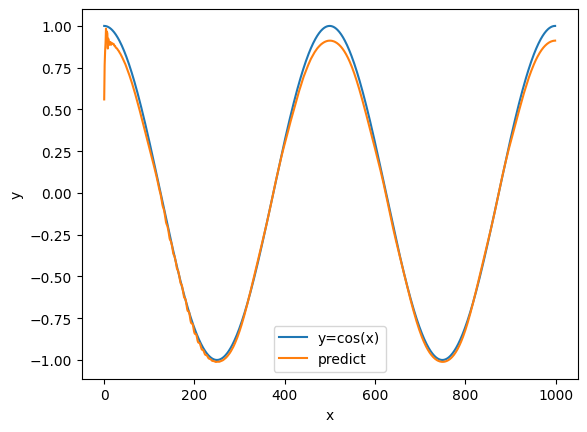

In [68]:
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Step 60 LSTM과 데이터 로더
1. 시계열 데이터용 데이터 로더 구현 (미니배치 단위로 순전파하기 위해)
2. LSTM 구현

In [69]:
class SeqDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, gpu=False):
        super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False, gpu=gpu)

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration
        
        jump = self.data_size // self.batch_size
        batch_index = [(i * jump + self.iteration) % self.data_size 
                            for i in range(self.batch_size)]
        batch = [self.dataset[i] for i in batch_index]

        xp = cuda.cupy if self.gpu else np
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])

        self.iteration += 1
        return x, t

In [72]:
# 사용 예
train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=3)
x, t = next(dataloader)
print(x)
print('-----------')
print(t)

[[-0.01961318]
 [ 0.89988895]
 [-0.86493415]]
-----------
[[ 0.05600148]
 [ 0.85109836]
 [-0.8427038 ]]


In [73]:
class LSTM(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()

        H, I = hidden_size, in_size
        self.x2f = Linear(H, in_size=I)
        self.x2i = Linear(H, in_size=I)
        self.x2o = Linear(H, in_size=I)
        self.x2u = Linear(H, in_size=I)
        self.h2f = Linear(H, in_size=H, nobias=True)
        self.h2i = Linear(H, in_Size=H, nobias=True)
        self.h2o = Linear(H, in_size=H, nobias=True)
        self.h2u = Linear(H, in_size=H, nobias=True)
        self.reset_state()

    def reset_state(self):
        self.h = None
        self.c = None
    
    def forward(self, x):
        if self.h is None:
            f = F.sigmoid(self.x2f(x))
            i = F.sigmoid(self.x2i(x))
            o = F.sigmoid(self.x2o(x))
            u = F.tanh(self.x2u(x))
        else:
            f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
            i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
            o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
            u = F.tanh(self.x2u(x) + self.h2u(self.h))
        
        if self.c is None:
            c_new = (i * u)
        else:
            c_new = (f * self.c) + (i * u)
        
        h_new = o * F.tanh(c_new)
        
        self.h, self.c = h_new, c_new
        return h_new

In [74]:
# 시계열 데이터로더와 LSTM 사용하여 Sine wave 학습 
max_epoch = 100
hidden_size = 100
bptt_length = 30
train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=batch_size)
seqlen = len(train_set)

class BetterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.LSTM(hidden_size)
        self.fc = L.Linear(out_size)
    
    def reset_state(self):
        self.rnn.reset_state()
    
    def forward(self, x):
        y = self.rnn(x)
        y = self.fc(y)
        return y

model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1
        
        # Truncated BPTT 타이밍 조정
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
        
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.012510
| epoch 2 | loss 0.134728
| epoch 3 | loss 0.030184
| epoch 4 | loss 0.024309
| epoch 5 | loss 0.011705
| epoch 6 | loss 0.006360
| epoch 7 | loss 0.004151
| epoch 8 | loss 0.002755
| epoch 9 | loss 0.002743
| epoch 10 | loss 0.002384
| epoch 11 | loss 0.002741
| epoch 12 | loss 0.002650
| epoch 13 | loss 0.003030
| epoch 14 | loss 0.002833
| epoch 15 | loss 0.002972
| epoch 16 | loss 0.002681
| epoch 17 | loss 0.002713
| epoch 18 | loss 0.002552
| epoch 19 | loss 0.002577
| epoch 20 | loss 0.002527
| epoch 21 | loss 0.002522
| epoch 22 | loss 0.002514
| epoch 23 | loss 0.002478
| epoch 24 | loss 0.002476
| epoch 25 | loss 0.002434
| epoch 26 | loss 0.002427
| epoch 27 | loss 0.002398
| epoch 28 | loss 0.002386
| epoch 29 | loss 0.002369
| epoch 30 | loss 0.002356
| epoch 31 | loss 0.002344
| epoch 32 | loss 0.002332
| epoch 33 | loss 0.002321
| epoch 34 | loss 0.002310
| epoch 35 | loss 0.002300
| epoch 36 | loss 0.002291
| epoch 37 | loss 0.002282
| epoch 38

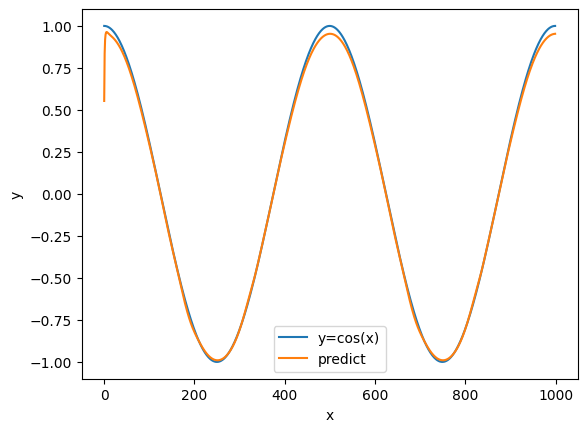

In [75]:
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()